In [ ]:
import rasterio
from rasterio.warp import transform as warp_transform
#https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class#Example-Notebook
import dask.array as da
import dask.distributed
from matplotlib.colors import ListedColormap
import pystac_client
import pyproj
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import planetary_computer
import rasterio
import rasterio.features
import stackstac
from pystac.extensions.eo import EOExtension as eo
import dask.dataframe as dd
import datetime
import odc.stac
import rioxarray
import time


In [ ]:
import glob
import os

# Path to the directory
#directory_path = 'D:\\GlobalPCL_CO\\'
directory_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Tiles\\'

# Pattern to match all .tif files
pattern = '*.tif'

# Construct full pattern path
full_pattern = directory_path + pattern

# List all .tif files in the directory
tif_files = glob.glob(full_pattern)
#tif_files = tif_files[0]

# Initialize an empty list to store filenames without extensions
filenames_without_extension = []

# Loop through each file in the list for naming convention 
for file_path in tif_files:
    filename_with_extension = os.path.basename(file_path)
    filename_without_extension = os.path.splitext(filename_with_extension)[0]
    filenames_without_extension.append(filename_without_extension)

#filenames_without_extension = filenames_without_extension[0]
print(filenames_without_extension[0])
print(len(filenames_without_extension))

In [ ]:
for w in range(1):#len(tif_files)):
    #try:
    start_time = datetime.datetime.now()

    # Path to your GeoTIFF files
    tif_path = tif_files[w]

    # Open the GeoTIFF file
    with rasterio.open(tif_path) as src:
        array = src.read()
        # Get the dimensions of the array
        bands, height, width = array.shape
        # Get the affine transformation for the GeoTIFF
        affine_transform = src.transform

        # Get the dimensions of the image
        width = src.width
        height = src.height

        # Initialize a list to hold the coordinates
        wgs_coords = []

        # Loop over each pixel in the image
        for row in range(height):
            for col in range(width):
                # Get the x, y coordinates of the center of the pixel
                x, y = affine_transform * (col + 0.5, row + 0.5)

                # Transform the x, y coordinates to longitude, latitude (WGS84)
                lon, lat = warp_transform(src.crs, 'EPSG:4326', [x], [y])

                # Append the WGS84 coordinates to the list
                wgs_coords.append((lon[0], lat[0]))

    print(len(wgs_coords))

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    central_lon = sum(lon for lon, _ in wgs_coords) / len(wgs_coords)
    central_lat = sum(lat for _, lat in wgs_coords) / len(wgs_coords)

    #central_lon, central_lat = -105.556671,40.370342

    offset_lon, offset_lat = 0.25, 0.15  # Adjust these values as needed for the desired area

    # Create the bounding box around Fort Collins, Colorado
    bbox_of_interest = [
        central_lon - offset_lon,  # Min longitude (west boundary)
        central_lat - offset_lat,  # Min latitude (south boundary)
        central_lon + offset_lon,  # Max longitude (east boundary)
        central_lat + offset_lat   # Max latitude (north boundary)
    ]

    print("Bounding box: ", bbox_of_interest)

In [ ]:
# search = catalog.search(collections=["cop-dem-glo-30"], bbox=bbox_of_interest)

# items = search.item_collection()

# item = items[0]

search = catalog.search(
    collections=["cop-dem-glo-30"],
    bbox=bbox_of_interest
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

In [ ]:
        # Extract values across years for the given point LULC
      #  values_across_years_LULC = LULC_stack.sel(x=utm_x, y=utm_y, method='nearest')#.values
     #   df_list.append(values_across_years_LULC)

In [ ]:
# import rioxarray
# import xrspatial
# from datashader.transfer_functions import shade, stack
# from datashader.colors import Elevation
# from planetary_computer import sign

# # Assuming 'items' is already defined and contains at least 4 items
# for i in range(3):  # Processing the first four items
#     signed_asset = sign(items[i].assets["data"])
#     data = (
#         rioxarray.open_rasterio(signed_asset.href)
#         .squeeze()
#         .drop("band", errors="ignore")
#         .coarsen({"y": 5, "x": 5}, boundary="trim")
#         .mean()
#     )

#     # Generate hillshade
#     hillshade = xrspatial.hillshade(data)
#     # Generate color shading for the data
#     shaded_data = shade(data, cmap=Elevation, alpha=128)
#     shaded_hillshade = shade(hillshade, cmap=["white", "gray"])

#     # Combine the hillshade and colored data
#     combined = stack(shaded_hillshade, shaded_data)

#     # Convert to xarray DataArray to save as TIFF
#     import numpy as np
#     import xarray as xr

#     combined_array = xr.DataArray(
#         np.array(combined.to_pil(), dtype=np.uint8),
#         dims=["y", "x", "band"],
#         coords={"y": data.y, "x": data.x, "band": ["R", "G", "B"]}
#     )

#     # Write CRS information if it's missing
#     combined_array.rio.write_crs(data.rio.crs, inplace=True)

#     # Save each combined image as a TIFF
#     output_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\processed_data_item_{i}.tif"
#     combined_array.rio.to_raster(output_path)
#     print(f"Saved the image to {output_path}")


In [ ]:
signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)
signed_asset = planetary_computer.sign(items[1].assets["data"])
data2 = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)

import xarray as xr

# Assuming data and data2 are already defined as DataArrays

# Concatenate data and data2 along a new dimension called 'concat_dim'
DATATOTAL = xr.concat([data, data2], dim="y")  # Assuming 'y' is the common dimension

import rioxarray

# Assuming 'data' has been processed as you showed
# Set the CRS (coordinate reference system) from the original data if it hasn't been preserved
data.rio.write_crs("EPSG:4326", inplace=True)  # Change "EPSG:4326" to the appropriate CRS if different

# Specify the path where you want to save the TIFF file
output_tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\output_dataC3.tif"

# Save the data as a GeoTIFF file
DATATOTAL.rio.to_raster(output_tif_path)

print(f"Saved the processed data as a TIFF file at {output_tif_path}")





In [ ]:
data.rio.write_crs("EPSG:4326", inplace=True)  # Change "EPSG:4326" to the appropriate CRS if different

# Specify the path where you want to save the TIFF file
output_tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\output_dataC3data.tif"

# Save the data as a GeoTIFF file
data.rio.to_raster(output_tif_path)

print(f"Saved the processed data as a TIFF file at {output_tif_path}")


data.rio.write_crs("EPSG:4326", inplace=True)  # Change "EPSG:4326" to the appropriate CRS if different

# Specify the path where you want to save the TIFF file
output_tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\output_dataC3data2.tif"

# Save the data as a GeoTIFF file
data2.rio.to_raster(output_tif_path)

print(f"Saved the processed data as a TIFF file at {output_tif_path}")


In [ ]:
data

In [ ]:
signed_asset = planetary_computer.sign(items[3].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)
# signed_asset = planetary_computer.sign(items[2].assets["data"])
# data2 = (
#     rioxarray.open_rasterio(signed_asset.href)
#     .squeeze()
#     .drop("band")
#     .coarsen({"y": 5, "x": 5})
#     .mean()
# )

import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data, cmap=Elevation, alpha=128))

In [ ]:
signed_asset = planetary_computer.sign(items[1].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)
# signed_asset = planetary_computer.sign(items[2].assets["data"])
# data2 = (
#     rioxarray.open_rasterio(signed_asset.href)
#     .squeeze()
#     .drop("band")
#     .coarsen({"y": 5, "x": 5})
#     .mean()
# )

import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data, cmap=Elevation, alpha=128))

In [ ]:
import rioxarray

# Assuming 'data' has been processed as you showed
# Set the CRS (coordinate reference system) from the original data if it hasn't been preserved
data.rio.write_crs("EPSG:4326", inplace=True)  # Change "EPSG:4326" to the appropriate CRS if different

# Specify the path where you want to save the TIFF file
output_tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\output_dataC2.tif"

# Save the data as a GeoTIFF file
DATATOTAL.rio.to_raster(output_tif_path)

print(f"Saved the processed data as a TIFF file at {output_tif_path}")


In [ ]:
import datetime
import rasterio
from rasterio.warp import transform
from shapely.geometry import box
import pystac_client
from planetary_computer import sign_inplace

# Initialize the STAC client
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=sign_inplace)

# Assuming tif_files is already defined
for tif_path in tif_files[:1]:  # Using [:1] to process only the first file for example
    with rasterio.open(tif_path) as src:
        array = src.read()
        affine_transform = src.transform

        wgs_coords = []
        for row in range(src.height):
            for col in range(src.width):
                x, y = affine_transform * (col + 0.5, row + 0.5)
                lon, lat = transform(src.crs, 'EPSG:4326', [x], [y])
                wgs_coords.append((lon[0], lat[0]))

        central_lon = sum(lon for lon, _ in wgs_coords) / len(wgs_coords)
        central_lat = sum(lat for _, lat in wgs_coords) / len(wgs_coords)
        offset_lon, offset_lat = 0.25, 0.15  # Adjust these values as needed

        bbox_of_interest = [
            central_lon - offset_lon,
            central_lat - offset_lat,
            central_lon + offset_lon,
            central_lat + offset_lat
        ]

        # Search for data within the bounding box and time range
        search = catalog.search(
            collections=["cop-dem-glo-30"],  # Assuming Sentinel-2 data
            bbox=bbox_of_interest
        )

        # Fetch the items
        items = search.get_items()
        print(f"Found {len(items)} items")

        # Here, you would download the data and prepare it for the CNN input
        # For example, creating image chips, normalizing, etc.

# Implement CNN here
# Example:
# model = build_cnn_model()
# predictions = model.predict(image_chips)


In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
from planetary_computer import sas_blob

# Helper function to download and crop image around a given center (lon, lat)
def download_and_crop_image(item, lon, lat, size=256, band_indices=[1]):  # Example: RGB bands
    # Get the href and signed URL
    href = item.assets["B04"].href  # Assuming using Band 4 (Red) for simplicity
    signed_href = sas_blob(href)
    
    with rasterio.open(signed_href) as src:
        # Convert geographic coordinates to pixel coordinates
        py, px = src.index(lon, lat)
        # Define a window around the central pixel
        window = Window(px - size // 2, py - size // 2, size, size)
        # Read the specified bands within the window
        data = src.read(band_indices, window=window)
        return data

# Normalize image data
def normalize(image):
    return image / 65535.0  # Assuming 16-bit images

# Process each item in the search results
for item in search.get_items():
    print(f"Processing {item.id}")
    for lon, lat in wgs_coords:
        try:
            chip = download_and_crop_image(item, lon, lat)
            chip_normalized = normalize(chip)
            
            # Here you would add the normalized chip to your dataset for the CNN
            # E.g., dataset.append((chip_normalized, label)) where label is the PCL or other target variable

            # Optionally, perform data augmentation here

        except Exception as e:
            print(f"Error processing image chip at ({lon}, {lat}): {str(e)}")

# Now dataset would be ready to use in training a CNN


In [ ]:
### CNN 4_22_2024 ###

In [ ]:
import rasterio
from rasterio.warp import transform as warp_transform
#https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class#Example-Notebook
import dask.array as da
import dask.distributed
from matplotlib.colors import ListedColormap
import pystac_client
import pyproj
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import planetary_computer
import rasterio
import rasterio.features
import stackstac
from pystac.extensions.eo import EOExtension as eo
import dask.dataframe as dd
import datetime
import odc.stac
import rioxarray
import time

In [ ]:
# Coordinates for Fort Collins, CO

min_lon = -105.115
max_lon = -105.032
min_lat = 40.521
max_lat = 40.610

# Define the bounding box
bbox_of_interest = [min_lon, min_lat, max_lon, max_lat]

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
search = catalog.search(
    collections=["cop-dem-glo-30"],
    bbox=bbox_of_interest
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

In [ ]:
signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    #.coarsen({"y": 5, "x": 5})
    #.mean()
)

data.rio.write_crs("EPSG:4326", inplace=True)  # Change "EPSG:4326" to the appropriate CRS if different

# Specify the path where you want to save the TIFF file
output_tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\output_dataDEM.tif"

# Save the data as a GeoTIFF file
data.rio.to_raster(output_tif_path)

In [ ]:
# import os
# from itertools import product
# import rasterio as rio
# from rasterio import windows

# in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\'
# input_filename = 'output_dataDEM.tif'
# out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILES\\'
# output_filename = 'tile_{}-{}.tif'
# widthtile = 1000
# heighttile = 1000

# def get_tiles(ds, width=widthtile, height=heighttile):
#     nols, nrows = ds.meta['width'], ds.meta['height']
#     #offsets = product(range(0, nols, width), range(0, nrows, height))
#     offsets = product(range(0, nols, 200), range(0, nrows, 200))
#     big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
#     for col_off, row_off in offsets:
#         window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
#         transform = windows.transform(window, ds.transform)
#         yield window, transform

# with rio.open(os.path.join(in_path, input_filename)) as inds:
#     tile_width, tile_height = widthtile, heighttile
#     nodata = inds.nodata  # Get the NoData value from the dataset
#     meta = inds.meta.copy()

#     for window, transform in get_tiles(inds):
#         data = inds.read(window=window)
#         if nodata is not None:
#             # Modified check for NoData to include tolerance for floating-point rasters
#             valid_data_mask = (data != nodata)
#         else:
#             # If NoData value is not set, consider all data as valid
#             valid_data_mask = (data == data)

#         if valid_data_mask.any():  # Check if there's any valid data within the tile
#             meta['transform'] = transform
#             meta['width'], meta['height'] = window.width, window.height
#             outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
#             with rio.open(outpath, 'w', **meta) as outds:
#                 outds.write(data)
# print("done")

In [1]:
# this ensures all tiles are widthtile by heighttile
import os
from itertools import product
import rasterio as rio
from rasterio import windows

in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\'
input_filename = 'output_dataDEM.tif'
out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILES3\\'
output_filename = 'tile_{}-{}.tif'
widthtile = 300
heighttile = 300

def get_tiles(ds, width=widthtile, height=heighttile):
    nols, nrows = ds.meta['width'], ds.meta['height']
    #offsets = product(range(0, nols, width), range(0, nrows, height))
    offsets = product(range(0, nols, 10), range(0, nrows, 10))

    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

with rio.open(os.path.join(in_path, input_filename)) as inds:
    tile_width, tile_height = widthtile, heighttile
    nodata = inds.nodata  # Get the NoData value from the dataset
    meta = inds.meta.copy()

    for window, transform in get_tiles(inds):
        if window.width == tile_width and window.height == tile_height:  # Check if the tile dimensions are as expected
            data = inds.read(window=window)
            if nodata is not None:
                # Modified check for NoData to include tolerance for floating-point rasters
                valid_data_mask = (data != nodata)
            else:
                # If NoData value is not set, consider all data as valid
                valid_data_mask = (data == data)

            if valid_data_mask.any():  # Check if there's any valid data within the tile
                meta['transform'] = transform
                meta['width'], meta['height'] = window.width, window.height
                outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
                with rio.open(outpath, 'w', **meta) as outds:
                    outds.write(data)

print("Done")


Done


In [4]:
import os
import rasterio
from rasterio.transform import rowcol
import numpy as np

# Path to the directory containing your TIFF tiles
tiles_directory = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILES3\\'

# Path to the TIFF file containing the PCL data
pcl_tif_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Input\\pcl_west_wgs_CO.tif'

# Lists to store image data and labels (assuming all tiles are the same size and have the same number of bands)
images = []
labels = []

# Count number of files to preallocate arrays
num_files = len([name for name in os.listdir(tiles_directory) if name.endswith('.tif')])
first_file = True


i=0
# Open the PCL data TIFF file
with rasterio.open(pcl_tif_path) as pcl_src:
    pcl_data = pcl_src.read(1)  # Read the first band

    # Loop through each tile in the directory
    for filename in os.listdir(tiles_directory):
        #print(i)

        if filename.endswith(".tif"):
            filepath = os.path.join(tiles_directory, filename)
            with rasterio.open(filepath) as src:
                data = src.read()  # Read all bands of the tile
                if first_file:
                    # Initialize the numpy arrays with correct dimensions
                    images = np.zeros((num_files, *data.shape), dtype=data.dtype)
                    labels = np.zeros(num_files, dtype=np.float32)
                    idx = 0
                    first_file = False
                images[idx] = data
                # Calculate the geographic coordinates of the center pixel of the tile
                center_x, center_y = (src.width // 2, src.height // 2)
                lon, lat = src.xy(center_y, center_x)  # Get lon and lat of the center pixel

                # Convert geographic coordinates to row and col in the PCL TIFF
                pcl_row, pcl_col = rowcol(pcl_src.transform, lon, lat)

                # Extract the PCL value at this position
                center_pcl_value = pcl_data[pcl_row, pcl_col]
                labels[idx] = center_pcl_value  # Append the PCL value as label
                idx += 1
        #i=i+1

# Check shapes
print("Shape of the images array:", images.shape)
print("Shape of the labels array:", labels.shape)


Shape of the images array: (109561, 1, 300, 300)
Shape of the labels array: (109561,)


In [ ]:
import numpy as np


labels = labels / 100.0  # Scale labels to [0, 1]

# Assuming `images` is a NumPy array with shape (num_samples, height, width, 1)
# Calculate the global minimum and maximum values across all images
global_min = images.min()
global_max = images.max()

# Function to scale images
def scale_images(images, global_min, global_max):
    return (images - global_min) / (global_max - global_min)

# Scale the images
scaled_images = scale_images(images, global_min, global_max)

# Checking the new shape and scaled values
print("Scaled images shape:", scaled_images.shape)
print("Min value in scaled images:", scaled_images.min())
print("Max value in scaled images:", scaled_images.max())


In [6]:
len(labels )

109561

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Reshape images to fit the model input
images = images.reshape(109561, 300, 300, 1)  # Reshape for CNN input

# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # Assuming a regression output
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

# Train the model
model.fit(images, labels, epochs=1, batch_size=64, validation_split=0.2)


# Save the model to a HDF5 file
model.save('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\SavedModels\\model_300by300.h5')

# # Later or in another script after re-importing the necessary libraries
# # Load the model back from the file
# loaded_model = tf.keras.models.load_model('my_model.h5')

# # Check the architecture of the loaded model
# loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

C:\Users\smdur\anaconda3\envs\globalpcl\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3424/3424 [==============================] - 618s 180ms/step


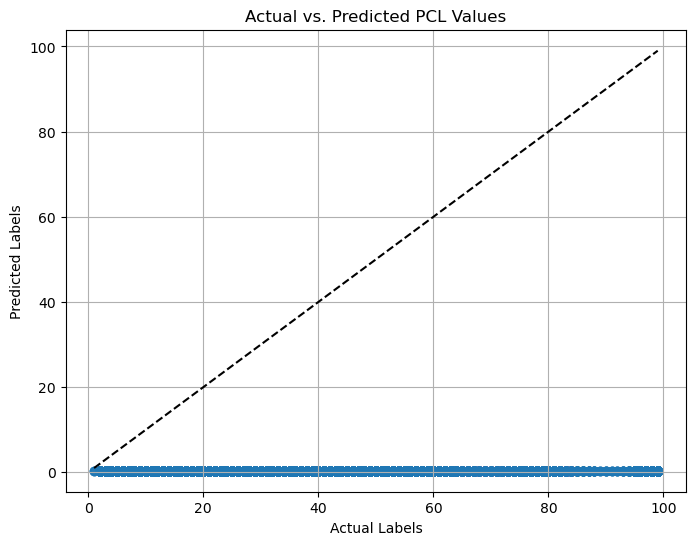

Mean Squared Error: 1872.02
R^2 Score: -0.82


In [16]:
import matplotlib.pyplot as plt

# Predict labels using the trained model
predicted_labels = model.predict(images).flatten()  # Flatten to make it 1D, matching labels' shape

# Scatter plot of Actual vs. Predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(labels, predicted_labels, alpha=0.5)
plt.title('Actual vs. Predicted PCL Values')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.grid(True)
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--')  # Line for perfect predictions
plt.show()

# Optionally, display the error metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(labels, predicted_labels)
r2 = r2_score(labels, predicted_labels)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')


# INFERENCE

In [ ]:
import os
from itertools import product
import rasterio as rio
from rasterio import windows

in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTIF\\'
input_filename = 'output_dataDEM.tif'
out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInference\\'
output_filename = 'tile_{}-{}.tif'
widthtile = 500
heighttile = 500

def get_tiles(ds, width=widthtile, height=heighttile):
    nols, nrows = ds.meta['width'], ds.meta['height']
    #offsets = product(range(0, nols, width), range(0, nrows, height))
    offsets = product(range(0, nols, 10), range(0, nrows, 10))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

with rio.open(os.path.join(in_path, input_filename)) as inds:
    tile_width, tile_height = widthtile, heighttile
    nodata = inds.nodata  # Get the NoData value from the dataset
    meta = inds.meta.copy()

    for window, transform in get_tiles(inds):
        data = inds.read(window=window)
        if nodata is not None:
            # Modified check for NoData to include tolerance for floating-point rasters
            valid_data_mask = (data != nodata)
        else:
            # If NoData value is not set, consider all data as valid
            valid_data_mask = (data == data)

        if valid_data_mask.any():  # Check if there's any valid data within the tile
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
            with rio.open(outpath, 'w', **meta) as outds:
                outds.write(data)
print("done")

In [ ]:
# import os
# from itertools import product
# import rasterio as rio
# from rasterio import windows

# in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInference\\tile_0-0.tif'
# out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInferenceSubset\\'
# output_filename = 'tile_{}-{}.tif'
# widthtile = 200
# heighttile = 200

# def get_tiles(ds, width=widthtile, height=heighttile):
#     nols, nrows = ds.meta['width'], ds.meta['height']
#     #offsets = product(range(0, nols, width), range(0, nrows, height))
#     offsets = product(range(0, nols, 1), range(0, nrows, 1))
#     big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
#     for col_off, row_off in offsets:
#         window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
#         transform = windows.transform(window, ds.transform)
#         yield window, transform

# with rio.open(os.path.join(in_path, input_filename)) as inds:
#     tile_width, tile_height = widthtile, heighttile
#     nodata = inds.nodata  # Get the NoData value from the dataset
#     meta = inds.meta.copy()

#     for window, transform in get_tiles(inds):
#         data = inds.read(window=window)
#         if nodata is not None:
#             # Modified check for NoData to include tolerance for floating-point rasters
#             valid_data_mask = (data != nodata)
#         else:
#             # If NoData value is not set, consider all data as valid
#             valid_data_mask = (data == data)

#         if valid_data_mask.any():  # Check if there's any valid data within the tile
#             meta['transform'] = transform
#             meta['width'], meta['height'] = window.width, window.height
#             outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
#             with rio.open(outpath, 'w', **meta) as outds:
#                 outds.write(data)
# print("done")

In [ ]:
# import numpy as np
# import rasterio
# from tensorflow.keras.models import load_model

# def extract_patches_overlap(image, patch_size=200, overlap=199):
#     """Extracts overlapping patches from the image."""
#     patches = []
#     stride = patch_size - overlap
#     for i in range(0, image.shape[0] - patch_size + 1, stride):
#         #print(i)
#         for j in range(0, image.shape[1] - patch_size + 1, stride):
#             patch = image[i:i+patch_size, j:j+patch_size]
#             if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
#                 patches.append(patch)
#     return np.array(patches)

# # Load your large image (assuming it's grayscale)
# with rasterio.open('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInference\\tile_0-0.tif') as src:
#     large_image = src.read(1)  # Read the first band

# # Example usage
# image_patches = extract_patches_overlap(large_image)


# # Reshape for prediction if necessary
# image_patches = image_patches.reshape(-1, 200, 200, 1)  # Add channel dimension

# # Predict on the patches
# predictions = model.predict(image_patches)


In [ ]:
# def reassemble_patches(predictions, original_shape, patch_size=200, overlap=199):
#     stride = patch_size - overlap
#     output_image = np.zeros(original_shape)
#     count_matrix = np.zeros(original_shape)  # To count the number of contributions to each pixel

#     k = 0  # Index for iterating over predictions
#     for i in range(0, original_shape[0] - patch_size + 1, stride):
#         for j in range(0, original_shape[1] - patch_size + 1, stride):
#             if len(predictions.shape) == 4:  # Check if predictions are 4D
#                 patch_prediction = predictions[k, :, :, 0]  # Assuming grayscale predictions
#             elif len(predictions.shape) == 3:  # Check if predictions are 3D (grayscale)
#                 patch_prediction = predictions[k]
#             else:
#                 raise ValueError("Invalid predictions shape.")
            
#             output_image[i:i + patch_size, j:j + patch_size] += patch_prediction
#             count_matrix[i:i + patch_size, j:j + patch_size] += 1
#             k += 1

#     # Avoid division by zero
#     output_image /= count_matrix
#     return output_image

# # Assuming 'predictions' are already reshaped if needed and 'large_image' is the original large image loaded earlier
# reassembled_image = reassemble_patches(predictions, large_image.shape)


In [ ]:
# import rasterio
# from rasterio.transform import from_origin

# # Use the metadata from the original image to keep geospatial information intact
# with rasterio.open('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInference\\tile_0-0.tif') as src:
#     meta = src.meta.copy()

# # Update the metadata to accommodate the new data type and format
# meta.update({
#     'dtype': 'float32',
#     'count': 1  # Number of bands
# })

# # Save the reassembled image
# output_tif_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Predicted_DEM.tif'
# with rasterio.open(output_tif_path, 'w', **meta) as dst:
#     dst.write(reassembled_image.astype(rasterio.float32), 1)


In [9]:
# def extract_patches_overlap(image, transform, patch_size=200, overlap=199):
#     """Extracts overlapping patches from the image along with their top-left coordinates."""
#     patches = []
#     coords = []
#     stride = patch_size - overlap
#     for i in range(0, image.shape[0] - patch_size + 1, stride):
#         for j in range(0, image.shape[1] - patch_size + 1, stride):
#             patch = image[i:i + patch_size, j:j + patch_size]
#             if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
#                 patches.append(patch)
#                 # Get the geographic coordinates for the top-left corner of the patch
#                 x, y = transform * (j, i)
#                 coords.append((x, y))
#     return np.array(patches), coords

def extract_patches_overlap(image, transform, patch_size=300, overlap=299):
    """Extracts overlapping patches from the image along with their center coordinates."""
    half_patch = patch_size // 2
    stride = patch_size - overlap
    patches = []
    coords = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
                # Get the geographic coordinates for the center of the patch
                x, y = transform * (j + half_patch, i + half_patch)
                coords.append((x, y))
    return np.array(patches), coords



with rasterio.open('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInference\\tile_0-10.tif') as src:
    large_image = src.read(1)  # Read the first band
    transform = src.transform  # Spatial transform for coordinate conversion

image_patches, patch_coords = extract_patches_overlap(large_image, transform)

image_patches = image_patches.reshape(-1, 300, 300, 1)  # Add channel dimension
predictions = model.predict(image_patches)

1263/1263 [==============================] - 213s 168ms/step


In [14]:
predictions

array([[0.36756113],
       [0.36756113],
       [0.36756113],
       ...,
       [0.36756113],
       [0.36756113],
       [0.36756113]], dtype=float32)

In [15]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio as rio
import geopandas as gpd
import xarray as xr
import rioxarray

# Create a GeoDataFrame from these coordinates
gdf = gpd.GeoDataFrame({
    'geometry': [Point(x, y) for x, y in patch_coords]
}, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system

# Extract x and y coordinates
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y
gdf['prediction'] = predictions  
# Now you have gdf with x, y columns along with geometry
print(gdf.head())

import xarray as xr
da = (
    gdf.set_index(["y", "x"])
    .prediction
    .to_xarray()
)
da.rio.to_raster("C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\OutputTIF\\output_file0_10_300w300h.tif")

                      geometry           x          y  prediction
0  POINT (-105.95847 40.95569) -105.958472  40.955694    0.367561
1  POINT (-105.95819 40.95569) -105.958194  40.955694    0.367561
2  POINT (-105.95792 40.95569) -105.957917  40.955694    0.367561
3  POINT (-105.95764 40.95569) -105.957639  40.955694    0.367561
4  POINT (-105.95736 40.95569) -105.957361  40.955694    0.367561


In [ ]:



from osgeo import gdal, ogr

# List of coordinates in the format (x, y)
coordinates = patch_coords

# Define output raster file path
output_raster = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\OutputTIF\\output_raster.tif'

# Define the path to your GeoTIFF file for resolution extraction
geotiff_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\DEMTILESInference\\tile_0-0.tif'

# Open the GeoTIFF file to get resolution information
geotiff_ds = gdal.Open(geotiff_path)
if geotiff_ds is None:
    raise FileNotFoundError(f"Failed to open {geotiff_path}")

# Get the geotransform parameters
geotransform = geotiff_ds.GetGeoTransform()
if geotransform is None:
    raise ValueError(f"No geotransform found in {geotiff_path}")

# Extract resolution from the geotransform
x_res = geotransform[1]
y_res = abs(geotransform[5])  # Make sure to use the absolute value for y resolution

# Close the GeoTIFF dataset
geotiff_ds = None

# Create a new GDAL memory datasource for points
driver = ogr.GetDriverByName('Memory')
point_ds = driver.CreateDataSource('')
point_layer = point_ds.CreateLayer('points', geom_type=ogr.wkbPoint)

# Add points to the layer
for coord in coordinates:
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(coord[0], coord[1])
    feature = ogr.Feature(point_layer.GetLayerDefn())
    feature.SetGeometry(point)
    point_layer.CreateFeature(feature)
    feature = None

# Get the extent from the point layer
x_min, x_max, y_min, y_max = point_layer.GetExtent()

# Create the output raster dataset
target_ds = gdal.GetDriverByName('GTiff').Create(output_raster, int((x_max - x_min) / x_res), int((y_max - y_min) / y_res), 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((x_min, x_res, 0, y_max, 0, -y_res))  # Set the geotransform (origin, pixel size, rotation)
target_ds.GetRasterBand(1).SetNoDataValue(-9999)  # Set nodata value

# Rasterize the points onto the target raster
gdal.RasterizeLayer(target_ds, [1], point_layer, options=['ATTRIBUTE=value'])

# Close the datasets
target_ds = None
point_ds = None


In [ ]:
# # Optionally, visualize patches and predictions
# import matplotlib.pyplot as plt

# # Display first few patches
# for i, patch in enumerate(image_patches[:5]):
#     plt.imshow(patch[:, :, 0], cmap='gray')  # Assuming grayscale patches
#     plt.title(f'Prediction: {predictions[i]}')
#     plt.show()


In [ ]:
# Create an output array
output_image = np.zeros(large_image.shape, dtype=np.float32)

# Fill the output array with predictions based on coordinates
for (x, y), prediction in zip(patch_coords, predictions):
    # Convert geographic coordinates back to array indices
    j, i = ~transform * (x, y)
    output_image[int(i):int(i) + 200, int(j):int(j) + 200] = prediction.reshape(200, 200)

# Save the output array as a new TIFF
with rasterio.open('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\OutputTIF\\output_predictions.tif', 'w', **src.meta) as dst:
    dst.write(output_image, 1)


In [ ]:
from osgeo import gdal, osr
import numpy as np

# Example coordinates
coords = [
    (-106.00013888888888, 41.00013888888889),
    (-105.9998611111111, 41.00013888888889),
    # Add the rest of your coordinates here...
]

# Raster dimensions
width = len(coords)
height = 1

# Output file
output_file = 'output_raster.tif'

# Create a new raster dataset
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(output_file, width, height, 1, gdal.GDT_Float32)

# Set geotransform (assuming each pixel represents 0.000277777 degrees in width)
x_min = min(coords)[0]
pixel_width = 0.000277777  # This should be calculated based on your specific coords spacing
geotransform = (x_min, pixel_width, 0, coords[0][1], 0, -pixel_width)
dataset.SetGeoTransform(geotransform)

# Set projection (assuming WGS84)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
dataset.SetProjection(srs.ExportToWkt())

# Create a raster band and write data
band = dataset.GetRasterBand(1)
raster = np.zeros((height, width), dtype=np.float32)
for i, coord in enumerate(coords):
    raster[0, i] = 1  # Or another value indicating presence

# Write the array to the raster band
band.WriteArray(raster)
band.FlushCache()

# Clean up
band = None
dataset = None
